# NLP: Yelp Review to Rating
## :)

In [1]:
# usual libs

import json
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# NLP lib
import nltk
import re, string, collections
from nltk.util import ngrams


# importing torch
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1) #for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");

In [2]:
# mo imports
import itertools
import os

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import time
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset

from torch.utils.data import DataLoader

import torchtext

from gensim.utils import simple_preprocess

In [ ]:
def load_yelp_orig_data():
    PATH_TO_YELP_REVIEWS = './yelp_review_training_dataset.jsonl'

    # read the entire file into a python array
    with open(PATH_TO_YELP_REVIEWS, 'r') as f:
        data = f.readlines()

    # remove the trailing "\n" from each line
    data = map(lambda x: x.rstrip(), data)

    data_json_str = "[" + ','.join(data) + "]"

    # now, load it into pandas
    data_df = pd.read_json(data_json_str)

    data_df.to_csv('./output_reviews_top.csv')
    
load_yelp_orig_data()

In [3]:
yelp = pd.read_csv('./output_reviews_top.csv')
yelp.head();

/home/tanvee/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
rev_len = yelp['text'].str.len()
yelp.drop(columns = ['Unnamed: 0'], axis = 1, inplace = True)
yelp.insert(2, "length", rev_len, True)
yelp.head()

,review_id,text,length,stars
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,204.0,1.0
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,1561.0,5.0
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,615.0,5.0
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,407.0,5.0
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,3509.0,1.0


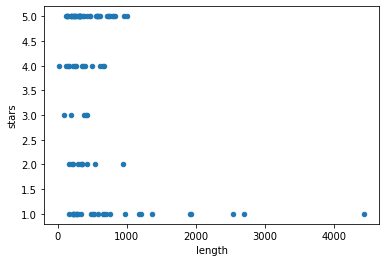

In [7]:
random_plot = yelp.sample(100)
random_plot.plot.scatter(x = 'length', y = 'stars')

ok so length means nothing really, but it looks like there is a bit of a class imbalance as demonstrated by the visualization below

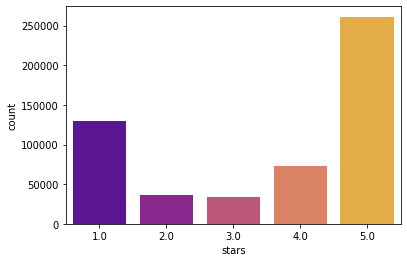

In [8]:
sns.countplot(yelp['stars'], palette = 'plasma')

/home/tanvee/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


stars
1.0    741.227506
2.0    701.123013
3.0    612.270058
4.0    523.488388
5.0    449.518171
Name: length, dtype: float64

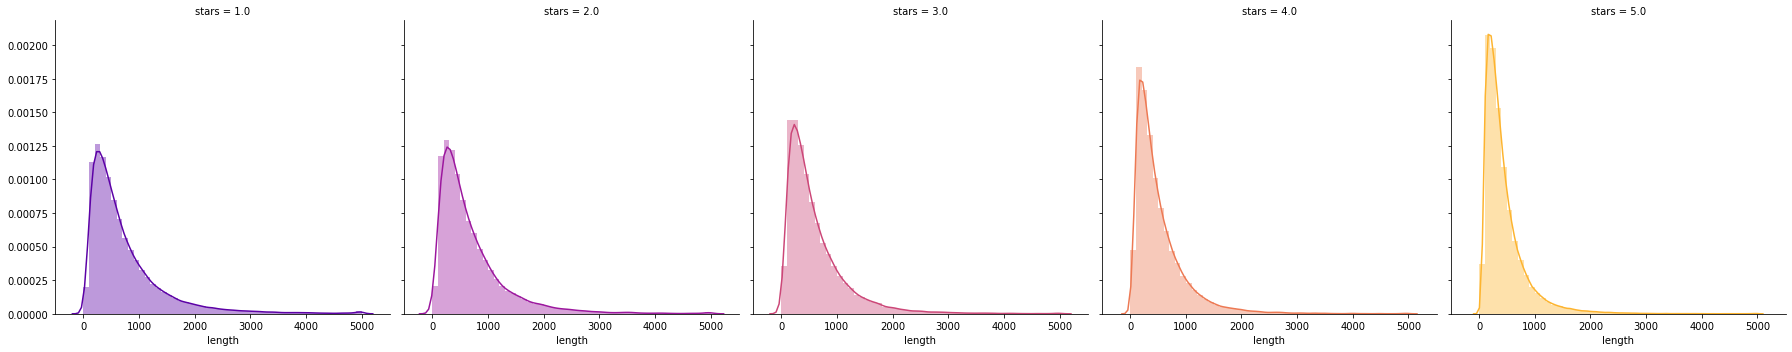

In [9]:
a = sns.FacetGrid(data = yelp, col = 'stars', hue = 'stars', palette='plasma', size=5)
a.map(sns.distplot, "length")
yelp.groupby('stars').mean()['length']

interesting...

In [5]:
yelp['tokenized'] = [simple_preprocess(str(line), deacc=True) for line in yelp['text']]
yelp.head()

,review_id,text,length,stars,tokenized
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,204.0,1.0,"[total, bill, for, this, horrible, service, ov..."
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,1561.0,5.0,"[adore, travis, at, the, hard, rock, new, kell..."
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,615.0,5.0,"[have, to, say, that, this, office, really, ha..."
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,407.0,5.0,"[went, in, for, lunch, steak, sandwich, was, d..."
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,3509.0,1.0,"[today, was, my, second, out, of, three, sessi..."


In [6]:
from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()
yelp['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in yelp['tokenized']]
yelp.head()

,review_id,text,length,stars,tokenized,stemmed_tokens
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,204.0,1.0,"[total, bill, for, this, horrible, service, ov...","[total, bill, for, thi, horribl, servic, over,..."
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,1561.0,5.0,"[adore, travis, at, the, hard, rock, new, kell...","[ador, travi, at, the, hard, rock, new, kelli,..."
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,615.0,5.0,"[have, to, say, that, this, office, really, ha...","[have, to, sai, that, thi, offic, realli, ha, ..."
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,407.0,5.0,"[went, in, for, lunch, steak, sandwich, was, d...","[went, in, for, lunch, steak, sandwich, wa, de..."
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,3509.0,1.0,"[today, was, my, second, out, of, three, sessi...","[todai, wa, my, second, out, of, three, sessio..."


In [ ]:
# train_size = int(len(yelp) * .7)
# train_posts = yelp['text'][:train_size]
# train_tags = yelp['stars'][:train_size]

# test_posts = yelp['text'][train_size:]
# test_tags = yelp['stars'][train_size:]

In [12]:
# Train Test Split Function
def split_train_test(og, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(yelp[['review_id', 'text', 'stemmed_tokens']], 
                                                        yelp['stars'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train stars")
    print(Y_train.value_counts())
    print("Value counts for Test stars")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(yelp)

Value counts for Train stars
5.0    183082
1.0     90513
4.0     50730
2.0     25150
3.0     24030
Name: stars, dtype: int64
Value counts for Test stars
5.0    78077
1.0    39365
4.0    21692
2.0    10708
3.0    10233
Name: stars, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
    index               review_id  \
0  332417  pbpE4BoZW1QJ4Zt0vTwnGQ   
1   25060  btTjyHlMwcUudtnUVSgS9g   
2  435472  ef9tYSpiExx8zYMzUqLoaA   
3  405775  hHbUbUrCf9VuoqC8vLyqyw   
4   56760  fOYEnjgoFbTqrXYHN9myig   

                                                text  \
0  I ordered a bin to be delivered last Friday, i...   
1  Jolina's is fantastic.  I could eat the sleek ...   
2  Outside of Iceland and New Iceland (Gimli, Man...   
3  Bought a groupon for a Hoover Dam deluxe tour....   
4  Danny was great! He made our party a huge succ...   

                                      stemmed_tokens  
0  [order, bin, to, be, deliv, last, fridai, it, ...  
1  [jolina, 

In [39]:
# class PandasDataset(Dataset):
#     def __init__(self, dataframe):
#         self.dataframe = dataframe
#         self.dataframe['text'] = self.dataframe['text'].str.lower()
#         self.dataframe['text'] = self.dataframe['text'].apply(split)

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, index):
#         return self.dataframe.iloc[index]
yelp.to_csv("stemmed")

In [19]:
from gensim.models import Word2Vec
size = 500
window = 3
min_count = 1
workers = 3
sg = 1

# Function to train word2vec model
def make_word2vec_model(dattta, padding=True, sg=1, min_count=1, size=500, workers=3, window=3):
    if  padding:
        print(len(dattta))
        temp_df = pd.Series(dattta['stemmed_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        word2vec_file =  './models/' + 'word2vec_' + str(size) + '_PAD.model'
    else:
        temp_df = dattta['stemmed_tokens']
        word2vec_file =  './models/' + 'word2vec_' + str(size) + '.model'
    w2v_model = Word2Vec(temp_df, min_count = min_count, size = size, workers = workers, window = window, sg = sg)

    w2v_model.save(word2vec_file)
    return w2v_model, word2vec_file

# Train Word2vec model
w2vmodel, word2vec_file = make_word2vec_model(yelp, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)


533582


In [33]:
print("hello!")
max_sen_len = yelp.stemmed_tokens.map(len).max()
def make_word2vec_vector_cnn(sentence):
    padded_X = [i for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.vocab:
            padded_X[i] = 0
            print(word)
        else:
            padded_X[i] = w2vmodel.wv.vocab[word].index
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

hello!


In [34]:
# Function to get the output tensor
def make_target(label):
    if label == -1:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 0:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)


In [35]:
EMBEDDING_SIZE = 500
NUM_FILTERS = 10
import gensim

class CnnTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, window_sizes=(1,2,3,5)):
        super(CnnTextClassifier, self).__init__()
        w2vmodel = gensim.models.KeyedVectors.load('./models/' + 'word2vec_500_PAD.model')
        weights = w2vmodel.wv
        # With pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        # Without pretrained embeddings
        # self.embedding = nn.Embedding(vocab_size, EMBEDDING_SIZE)

        self.convs = nn.ModuleList([
                                   nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
                                   for window_size in window_sizes
        ])

        self.fc = nn.Linear(NUM_FILTERS * len(window_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x) # [B, T, E]

        # Apply a convolution + max_pool layer for each window size
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = torch.tanh(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        # FC
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        probs = F.softmax(logits, dim = 1)

        return probs

In [37]:
type(t['stars'][0])

numpy.float64

In [36]:
NUM_CLASSES = 3
VOCAB_SIZE = len(w2vmodel.wv.vocab)

cnn_model = CnnTextClassifier(vocab_size=VOCAB_SIZE, num_classes=NUM_CLASSES)
cnn_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
num_epochs = 30

# Open the file for writing loss
loss_file_name = './plots/' + 'cnn_class_big_loss_with_padding.csv'
f = open(loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
cnn_model.train()
for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1))
    train_loss = 0
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        cnn_model.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
       
        # Forward pass to get output
        probs = cnn_model(bow_vec)

        # Get the target label
        target = make_target(Y_train['stars'][index])

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()


    # if index == 0:
    #     continue
    print("Epoch ran :"+ str(epoch+1))
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

torch.save(cnn_model, './cnn_big_model_500_with_padding.pth')

f.close()
print("Input vector")
print(bow_vec.cpu().numpy())
print("Probs")
print(probs)
print(torch.argmax(probs, dim=1).cpu().numpy()[0])


Epoch1


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report
bow_cnn_predictions = []
original_lables_cnn_bow = []
cnn_model.eval()
loss_df = pd.read_csv(OUTPUT_FOLDER + 'cnn_class_big_loss_with_padding.csv')
print(loss_df.columns)
# loss_df.plot('loss')
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
        probs = cnn_model(bow_vec)
        _, predicted = torch.max(probs.data, 1)
        bow_cnn_predictions.append(predicted.cpu().numpy()[0])
        original_lables_cnn_bow.append(make_target(Y_test['stars'][index]).cpu().numpy()[0])
print(classification_report(original_lables_cnn_bow,bow_cnn_predictions))
loss_file_name = './plots/' + 'cnn_class_big_loss_with_padding.csv'
loss_df = pd.read_csv(loss_file_name)
print(loss_df.columns)
plt_500_padding_30_epochs = loss_df[' loss'].plot()
fig = plt_500_padding_30_epochs.get_figure()
fig.savefig(OUTPUT_FOLDER +'plots/' + 'loss_plt_500_padding_30_epochs.pdf")